# **An Exploratory Study on Zomato restaurants in India**

## **Prerequistes**

In [72]:
import pandas as pd  # Data cleaning preparation
import numpy as np # Data cleaning & preparation
import seaborn as sns # Plotting & visualisation
import matplotlib.pyplot as plt # Plotting & visualisation
import warnings # Filter warnings
from cmasher import take_cmap_colors # Get N color codes (RGB OR HEX)
from matplotlib import ticker as mtick
from matplotlib import dates as mdate
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib import patches, lines
from bs4 import BeautifulSoup
from datetime import datetime as dt
import requests
import random
import re

warnings.filterwarnings('ignore') # Ignoring warnings
pd.set_option('display.max_columns',50)

### Crucial Functions(Callables)

In [73]:
def extract_html_table(url, which= 0, columns=None):
    html= requests.get(url)
    soup= BeautifulSoup(html.content)
    body= soup.find_all('table',{'class':'wikitable'})[which].find('tbody')
    rows= [[i.text.strip('\n').strip() for i in row.find_all(['th','td'])] for row in body.find_all('tr')]
    cols= rows.pop(0)
    if columns is not None:
        return pd.DataFrame(rows, columns= cols)[columns]
    else:
        return pd.DataFrame(rows, columns= cols)

In [74]:
# Function for finding missing values/columns in the dataset
def find_missing_columns(data, percent=False):
  missing= df.isna().sum()[df.isna().sum() > 0].reset_index()
  missing.columns= ['columns','missing_values']
  if percent:
    missing['percent']= round(missing.missing_values/len(data), 4)
  return missing.set_index('columns').sort_values(by='missing_values', ascending=False)

In [75]:
# Function for getting color codes
def get_color_codes(name, size):
  return take_cmap_colors(name, size, return_fmt='hex')

# Function for random colors codes
def get_random_colors(n=1):
  if n==1:
    return get_color_codes(name= random.choice(plt.colormaps()), size=n)[0]
  else:
    return get_color_codes(name= random.choice(plt.colormaps()), size= n)

In [76]:
# To transform numbers to abbreviated format
def format_numbers(number, pos=None, fmt= '.0f'):
    fmt= '%'+fmt
    thousands, millions, billions= 1_000, 1_000_000, 1_000_000_000
    if number/billions >=1:
        return (fmt+'B') %(number/billions)
    elif number/millions >=1:
        return (fmt+'M') %(number/millions)
    elif number/thousands >=1:
        return (fmt+'K') %(number/thousands)
    else:
        return fmt %(number)

In [77]:
# to normalize data/series from 0 to 1
def normalize(data, axis=0):
    if axis==0:
        return data/data.sum()
    else:
        return (data.T/data.T.sum()).T

In [78]:
# to assert whether duplicate records present in the data and get summary of duplicated records
def has_duplicates(data):
    n_duplicates= data.duplicated().sum()
    if n_duplicates > 0:
        print('This dataset contains almost {} ({:.1%}) duplicate records.'.format(format_numbers(n_duplicates), n_duplicates/data.shape[0]))
    else:
        print('No duplicate records found.')

In [79]:
# to get skewness and kurotosis for numerical features of the given dataframe
def measures_of_symmetry(df, include_kurtosis=True):
    if include_kurtosis:
        return pd.concat([df.skew(), df.kurtosis()], axis=1).rename({0:'Skewness', 1: 'Kurtosis'}, axis=1)
    else:
        return df.skew()

In [80]:
# plotting function for comparing two continuous variables
def jointplot(data1, data2, hue=None):
    from matplotlib import gridspec
    fig= plt.figure(figsize= (8,6))
    gpec= gridspec.GridSpec(nrows= 3, ncols=4, figure= fig, wspace=0,hspace=0)

    ax= plt.subplot(gpec[0,:2])
    ax1= plt.subplot(gpec[1:,:3])
    ax2= plt.subplot(gpec[1:,-1])
    hist_kws= {'edgecolor':'grey', 'color':'blue'}
    kde_kws={'lw':2.5, 'color':'black', 'alpha':0.85}
    hist_kws2= {'edgecolor':'grey', 'color':'orange'}
    kde_kws2={'lw':2.5, 'color':'black', 'alpha':0.85}
    sns.distplot(data1, bins=15, ax=ax, hist_kws=hist_kws, kde_kws=kde_kws)
    sns.scatterplot(data1, data2, ax= ax1)
    sns.distplot(data2, bins=15, ax=ax2,vertical=True, hist_kws= hist_kws2, kde_kws=kde_kws2)
        
        
    ax.set_axis_off()
    ax2.set_axis_off()
    plt.tight_layout()
    sns.despine(offset= 10)

In [81]:
# Find whether x has any value, which matches in list of given values
def includes(x, list_of_values):
    result= []
    for i in x:
        if i in list_of_values:
            result.append(True)
        else:
            result.append(False)
    return result

## **Get Data**
- Import data of Zomato Restaurants in India.

In [82]:
# Just use the required columns
required_cols= ['res_id','name', 'establishment', 'city','locality', 'cuisines', 'timings', 
 'average_cost_for_two', 'price_range', 'highlights', 'aggregate_rating',
 'rating_text', 'votes', 'delivery']

In [83]:
# Load the data
df= pd.read_csv('zomato_restaurants_in_India.csv', usecols=required_cols)
df.head(3)

,res_id,name,establishment,city,locality,cuisines,timings,average_cost_for_two,price_range,highlights,aggregate_rating,rating_text,votes,delivery
0,3400299,Bikanervala,['Quick Bites'],Agra,Khandari,"North Indian, South Indian, Mithai, Street Foo...",8:30am – 10:30pm (Mon-Sun),700,2,"['Lunch', 'Takeaway Available', 'Credit Card',...",4.4,Very Good,814,-1
1,3400005,Mama Chicken Mama Franky House,['Quick Bites'],Agra,Agra Cantt,"North Indian, Mughlai, Rolls, Chinese, Fast Fo...","12:30PM to 12Midnight (Mon, Wed, Thu, Fri, Sat...",600,2,"['Delivery', 'No Alcohol Available', 'Dinner',...",4.4,Very Good,1203,-1
2,3401013,Bhagat Halwai,['Quick Bites'],Agra,Shahganj,"Fast Food, Mithai",9:30 AM to 11 PM,300,1,"['No Alcohol Available', 'Dinner', 'Takeaway A...",4.2,Very Good,801,1


## **Data Summary**

In [84]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211944 entries, 0 to 211943
Columns: 14 entries, res_id to delivery
dtypes: float64(1), int64(5), object(8)
memory usage: 22.6+ MB


In [85]:
# Data dimensions
print('Data shape:')
print('No of rows:', format_numbers(df.shape[0], fmt= '.1f'))
print('No of columns:', df.shape[1])

Data shape:
No of rows: 211.9K
No of columns: 14


In [86]:
# Find features with missing values
print(find_missing_columns(df, percent=True))

          missing_values  percent
columns                          
timings             3874   0.0183
cuisines            1391   0.0066


Aprroximately, only 1%  of the values are missing in **'timings'** and **'cuisines'**

In [87]:
# Lets see which columns contains -1 as a value.
df.apply(lambda x: (x==-1).any())

res_id                  False
name                    False
establishment           False
city                    False
locality                False
cuisines                False
timings                 False
average_cost_for_two    False
price_range             False
highlights              False
aggregate_rating        False
rating_text             False
votes                   False
delivery                 True
dtype: bool

Only delivery columns contains -1 as a value. We will 
treat -1 as missing values

In [88]:
# lets find out if there are any duplicate records in the dataset?
has_duplicates(df)

This dataset contains almost 152K (71.6%) duplicate records.


Almost 70% of the records are duplicate in the data.

## **Data cleaning and preparation**

### Cleaning and preprocessing

In [89]:
# Primarily, lets drop all the duplicate records
df= df.drop_duplicates(keep='first')

In [90]:
df.delivery= df.delivery.apply(lambda x: 0 if x==-1 else 1) # Replace delivery [-1] with Yes and vice versa. 
df.aggregate_rating= df.aggregate_rating.where(df.aggregate_rating!=0) # Replace ratings with 0 to nan.
df.establishment= df.establishment.apply(lambda x: re.sub('[\[\]\'\']','',x)) # unlist establishments to string
df.establishment= df.establishment.where(df.establishment!='') # Replace white spaced values in establishmnent with NaN.
# df.highlights= df.highlights.str.replace(r'[\[\]\']+','').str.split(',').apply(lambda x: [i.strip(' ') for i in x])
df['high']= df.highlights.str.replace(r'[\[\]\']','').str.split(',').apply(lambda x: [i.strip(' ') for i in x])
veg_filters= (df.high.apply(lambda x: any(includes(x, ['Pure Veg'])))) |  (df.high.apply(lambda x: any(includes(x, ['Serves Jain Food'])))) & (df.high.apply(lambda x: any(includes(x, ['Vegan Options']))))
df['veg']= veg_filters.astype(int) # Feature for distinguishing between Veg and Non-veg
df.cuisines[df.cuisines.isna()]='Not mentioned' # Replace missing values in cuisines
df.cuisines= df.cuisines.str.split(',').apply(lambda x: [i.strip(' ') for i in x]) # Convert multiple cuisines to list of strings
df['cuisine_count']= df.cuisines.str.len() # No of cuisines in each restaurant
df.average_cost_for_two= np.where(df.average_cost_for_two==0, 150, df.average_cost_for_two) # Replace 0 average cost with 200

In [91]:
# Create feature - Restaurant type

# list of establishments with for each restaurant type
pubs_bar_cafes= ['Bar','Café','Club','Cocktail Bar','Irani Cafe','Microbrewery','Lounge','Pub']
quick_bites= ['Beverage Shop','Butcher Shop','Quick Bites','Paan Shop','Kiosk', 'Food Truck','Pop up']
bakery_desserts_and_confectionaries= ['Bakery','Confectionary','Dessert Parlour','Sweet Shop']
casual_dining= ['Bhojanalya','Casual Dining','Dhaba','Food Court','Mess','Shack']
fine_dining= ['Fine Dining']

categories= [pubs_bar_cafes, quick_bites, bakery_desserts_and_confectionaries, casual_dining, fine_dining] # list of sub categories
names= ['Pubs, Bars & Cafes','Quick Bites','Bakery, desserts & Confectionary','Casual Dining','Fine Dining'] # new categories

# create mapping dict for replacing old sub categories with new categories
new_dict={}
for name, cat in zip(names, categories):
    new_dict.update(dict(zip(cat, [name for _ in range(len(cat))]))) # Update(Append) new dictionaries
    
df['type']= df.establishment.map(new_dict) # Create new feature with mapping dictionary.

### Web Scraping (Wikipedia)
- Find state name for respective cities from Wikipedia.
- Get Human Developnment index data of States and Union Territories from Wikipedia.

In [92]:
# Extract states for various cities with wikipedia
url= 'https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population'
states_data= extract_html_table(url=url, columns= ['City','State or union territory']) # Fetch only needed columns
states_data.columns= ['city','state'] # Renaming columns

# Text minining with features
states_data.city= states_data.city.str.replace(r'[\[\]\d]*','').str.strip(' ')
states_data.state= states_data.state.str.strip(' ')

# Merge states data with existing dataframe.
df= df.merge(states_data, on='city')

In [93]:
# Extract Human development index for all indian states and UTs.
url= 'https://en.wikipedia.org/wiki/List_of_Indian_states_and_union_territories_by_Human_Development_Index'
df1=  pd.read_html(url, attrs= {'class':'wikitable'})[0] # Fetch tables

# some data cleaning
high_hdi= df1.iloc[:14,1:3]
medium_hdi= df1.iloc[15:28,1:3]
low_hdi= df1.iloc[29:,1:3]

# New feature having HDI category
high_hdi['hdi_category']= 'High'
medium_hdi['hdi_category']= 'Medium'
low_hdi['hdi_category']= 'Low'

hdi= pd.concat([high_hdi, medium_hdi, low_hdi]) # Joining above three dataframes
hdi.columns= ['state','hdi','hdi_category'] # Renaming columns
hdi.hdi= pd.to_numeric(hdi.hdi, errors= 'coerce') # Convert hdi to appropriate datatype.
hdi.dropna(inplace=True)

In [94]:
# In this table, its found that Dadra and Nagar Haveli and Daman and Diu, has been given recorded separately. we need to join both the UTs.
hdi[(hdi.state=='Dadra and Nagar Haveli') | (hdi.state=='Daman and Diu')].hdi.mean()
hdi= hdi.append({'state':'Dadra and Nagar Haveli and Daman and Diu',
                 'hdi': 0.6855,
                 'hdi_category': 'Medium'}, 
                ignore_index=True)

hdi.drop(index= [11,23], inplace=True) # Drop rows with separate records
hdi.state= hdi.state.str.strip(' ')
df= pd.merge(df, hdi, on='state') # Merge HDI with df.

## **Exploratory Data Analysis**

### Descriptive summary statistics

In [95]:
## Descriptive Summary
print(df.iloc[:,1:-2].describe(percentiles= [0.25,0.50,0.65,0.70,0.75,0.95]).applymap('{:.2f}'.format))

      average_cost_for_two price_range aggregate_rating     votes  delivery  \
count             45205.00    45205.00         38306.00  45205.00  45205.00   
mean                515.98        1.68             3.64    245.20      0.32   
std                 558.89        0.85             0.51    713.11      0.47   
min                   2.00        1.00             1.80    -18.00      0.00   
25%                 200.00        1.00             3.30      8.00      0.00   
50%                 350.00        1.00             3.70     45.00      0.00   
65%                 500.00        2.00             3.90    108.00      0.00   
70%                 500.00        2.00             3.90    145.00      1.00   
75%                 600.00        2.00             4.00    197.00      1.00   
95%                1500.00        3.00             4.40   1089.00      1.00   
max               15000.00        4.00             4.90  42539.00      1.00   

            veg cuisine_count  
count  45205.00    

**Brief insights:**
- Average cost for two persons is around Rs. 500.
- 95% of restaurants have a Price range below 4 (On a scale of 1- 4)
- Average rating for all the restaurants is 3.6/5.
- There is a negative value in votes columns, which we need to omit as votes can't be of negative value.
- Almost 65% of restaurants provide online deliveries.

### Exploratory Analysis

In [96]:
print('The dataset contains data of {} restaurants from {} major cities of India.'.format(format_numbers(df.res_id.count()), df.city.nunique()))

The dataset contains data of 45K restaurants from 68 major cities of India.


In [97]:
print(f'\033[1m{df.state.nunique()} States names:\033[0m')
print(df.state.unique())

print(f'\033[1m{df.city.nunique()} Cities names:\033[0m')
print(df.city.unique())

23 States names:
['Uttar Pradesh' 'Gujarat' 'Rajasthan' 'Kerala' 'Punjab' 'Bihar'
 'Karnataka' 'Madhya Pradesh' 'Chandigarh' 'Haryana' 'Tamil Nadu' 'Odisha'
 'Uttarakhand' 'Delhi' 'Sikkim' 'Andhra Pradesh' 'Assam' 'Telangana'
 'Jammu and Kashmir' 'Jharkhand' 'West Bengal' 'Chhattisgarh'
 'Himachal Pradesh']
68 Cities names:
['Agra' 'Allahabad' 'Noida' 'Ghaziabad' 'Gorakhpur' 'Jhansi' 'Kanpur'
 'Lucknow' 'Meerut' 'Varanasi' 'Ahmedabad' 'Gandhinagar' 'Jamnagar'
 'Junagadh' 'Rajkot' 'Surat' 'Vadodara' 'Ajmer' 'Jaipur' 'Jodhpur' 'Kota'
 'Udaipur' 'Alappuzha' 'Kochi' 'Thrissur' 'Amritsar' 'Jalandhar'
 'Ludhiana' 'Patiala' 'Aurangabad' 'Patna' 'Bangalore' 'Mangalore' 'Udupi'
 'Mysore' 'Bhopal' 'Gwalior' 'Indore' 'Jabalpur' 'Chandigarh' 'Panchkula'
 'Gurgaon' 'Faridabad' 'Chennai' 'Coimbatore' 'Madurai' 'Salem' 'Vellore'
 'Cuttack' 'Dehradun' 'Haridwar' 'New Delhi' 'Gangtok' 'Guntur'
 'Vijayawada' 'Guwahati' 'Hyderabad' 'Secunderabad' 'Jammu' 'Srinagar'
 'Jamshedpur' 'Ranchi' 'Kharagpur' 'Kol

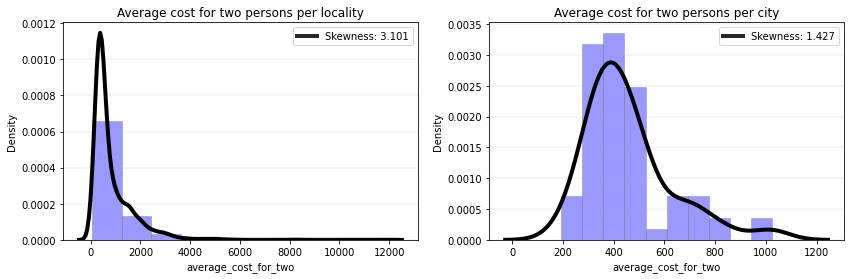

In [98]:
plt.figure(figsize= (14,4))
plt.subplot(121)
# Average cost for two per locality 
average_cost_per_locality= df.groupby('locality').average_cost_for_two.mean() 
sns.distplot(average_cost_per_locality, bins=10,hist_kws={'edgecolor':'grey', 'color':'blue'}, kde_kws={'lw':4, 'color':'black', 'alpha':0.85})
plt.grid(axis='y', lw=0.4,alpha=0.5)
plt.title('Average cost for two persons per locality')
plt.legend(handles= [lines.Line2D(xdata=[], ydata=[],linewidth=4, color='black', alpha=0.85, label= 'Skewness: %.3f'%average_cost_per_locality.skew())])

# Average cost for two per city
plt.subplot(122)
average_cost_per_city= df.groupby('city').average_cost_for_two.mean()
sns.distplot(average_cost_per_city, bins=10,hist_kws={'edgecolor':'grey', 'color':'blue'}, kde_kws={'lw':4, 'color':'black', 'alpha':0.85})
plt.grid(axis='y', lw=0.4,alpha=0.5)
plt.title('Average cost for two persons per city')
plt.legend(handles= [lines.Line2D(xdata=[], ydata=[],linewidth=4, color='black', alpha=0.85, label= 'Skewness: %.3f'%average_cost_per_city.skew())])
plt.show()

- Both plots are following a positively skewed distribution.
- Average cost for two persons per city could be in a range from 300-500.
- Average cost for two persons per locality would be under 1000.

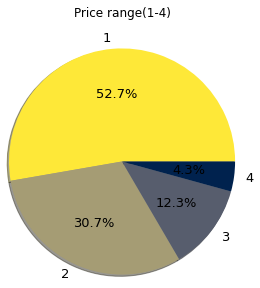

In [99]:
colors= get_color_codes('cividis_r',4)
df.price_range.value_counts().plot(kind='pie', autopct='%.1f%%', shadow=True, radius=1.3, textprops= {'size':13}, colors= colors)
plt.ylabel('')
plt.title('Price range(1-4)\n\n')
plt.show()

Almost half of the restaurants have a price range of 1(i.e, Average price would be around 200-300) 

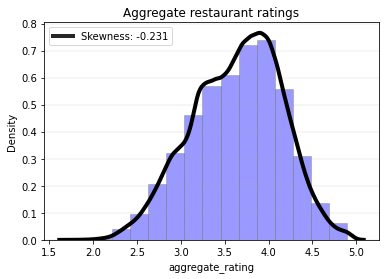

In [100]:
sns.distplot(df.aggregate_rating, bins=15,hist_kws={'edgecolor':'grey', 'color':'blue'}, kde_kws={'lw':4, 'color':'black', 'alpha':0.85})
plt.grid(axis='y', lw=0.4,alpha=0.5)
plt.title('Aggregate restaurant ratings')
plt.legend(handles= [lines.Line2D(xdata=[], ydata=[],linewidth=4, color='black', alpha=0.85, 
                                  label= 'Skewness: %.3f'%df.aggregate_rating.skew())])
plt.show()

Ratings are approximately near to normal(Gaussian) distribution.
Most of the restaurants are highly rated (4.0/5).

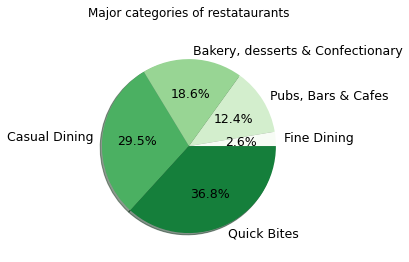

In [101]:
colors= get_color_codes('Greens', len(set(df.type)))
df.type.value_counts().sort_values().plot(kind='pie', colors= colors, shadow=True, autopct='%.1f%%', textprops= {'size':12.5})
plt.ylabel('')
plt.title('Major categories of restataurants\n')
plt.show()

Out of all the restaurants:
- Almost 35% of them are Quick bites.
- Followed by, Casual Dining having 30% out of total.
- Merely 2% out of the all are Fine Dining restaurants.

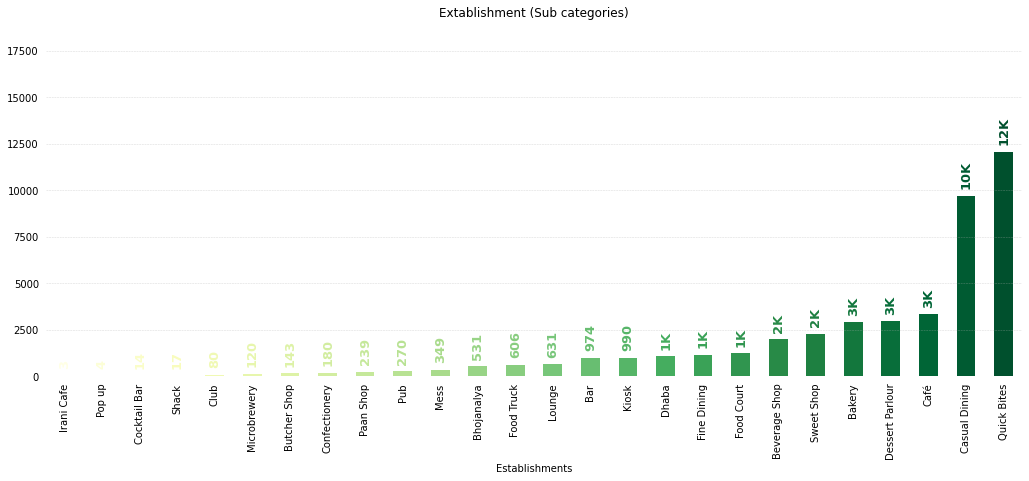

In [102]:
colors= get_color_codes('YlGn', len(set(df.establishment)))
df.establishment.value_counts().sort_values().plot(kind='bar', figsize= (17.5,6.5), color= colors)
plt.grid(axis='y', lw=0.5, alpha=0.5, ls='--')
plt.ylim(0,19000)
plt.title('Establishments of Zomato restaurants')
for i, rect in enumerate(plt.gca().patches):
    plt.annotate(xy= (rect.get_x(), rect.get_height()),xytext= (3,10),textcoords= 'offset points',
             text= format_numbers(rect.get_height(), fmt='.0f'), rotation=90, size=13, weight='bold', color= colors[i])
plt.title('Extablishment (Sub categories)')
plt.xlabel('Establishments')
for spine in plt.gca().spines: plt.gca().spines[spine].set_visible(False)
plt.gca().tick_params(left=False, bottom=False)
plt.show()

Out of all the establishments, Quick Bites and Casual dining are the most occuring restaurant establishments.

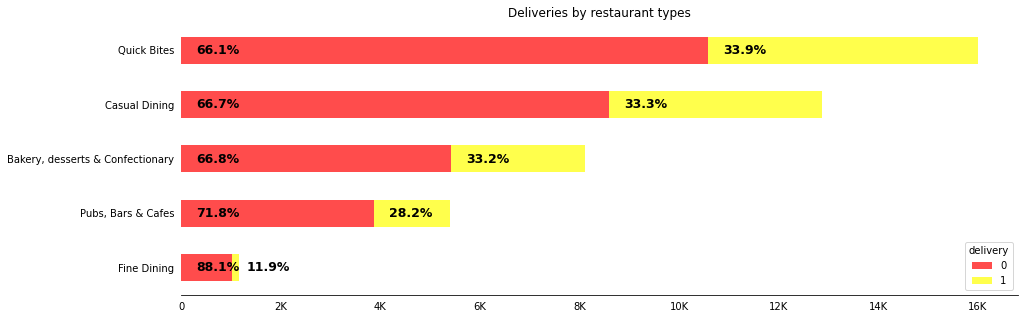

In [103]:
deliveries_by_major_types= pd.crosstab(df.type, df.delivery,margins=True)
color= get_color_codes(plt.cm.autumn, 2)
ax= (deliveries_by_major_types.sort_values(by='All').iloc[:-1,:-1]).plot(kind='barh', stacked=True, figsize= (15,5), color= color, alpha=0.7)
plt.title('Deliveries by restaurant types')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(format_numbers))
for i in ['left','top','right']: ax.spines[i].set_visible(False)
ax.tick_params(left=False, bottom=False)
plt.xlabel('')
plt.ylabel('')
deliveries_by_major_types.iloc[:-1,:-1]= normalize(deliveries_by_major_types.iloc[:-1,:-1], axis=1)
normalized_deliveries= deliveries_by_major_types.sort_values(by='All').iloc[:-1,:-1]
for i, bar in enumerate(plt.gca().containers):
    for j, rect in enumerate(bar):
        text= normalized_deliveries.iloc[j, i]
        ax.annotate(xy= rect.get_xy(), text= '{:.1%}'.format(text), xytext= (15,10), textcoords= 'offset points', size= 12.5, color='black', weight='bold')

- Only 10% out of all fine dining restaurants provide home deliveries.
- Quick Bites, Bakery, Desserts and confectionaries provide maximum deliveries(35%)

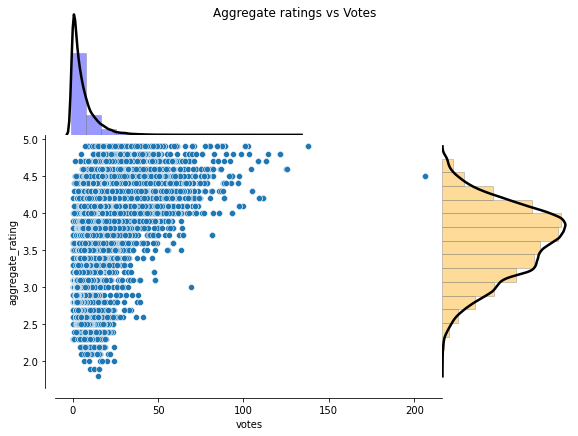

In [104]:
# Compare Aggregate ratings with Votes
jointplot(df.votes**0.5, df.aggregate_rating)
plt.suptitle('Aggregate ratings vs Votes')
plt.show()

In [105]:
# Function to fetch states by hdi category.
def hdi_states(category= 'low'):
    return hdi.state[hdi.hdi_category==category].to_list()

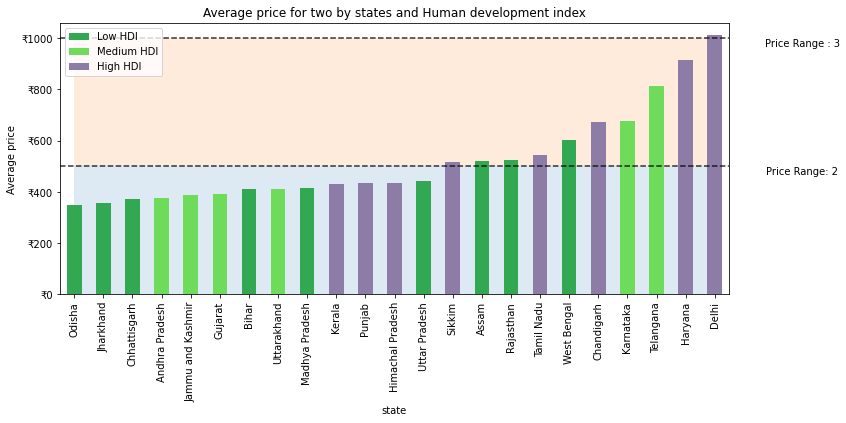

In [106]:
colors= ['#32a852','#6fdb5a','#8c7ca6']
mean_cost_by_price_range= df.groupby('price_range').average_cost_for_two.apply(lambda x: x.value_counts().index[0])
average_price_by_state=df.groupby('state').average_cost_for_two.mean().sort_values()
ax= average_price_by_state.plot(kind='bar',figsize=(12,5))
# plt.ylim(3,)
for rect, text in zip(ax.patches, [i.get_text() for i in ax.get_xticklabels()]):
    if text in hdi_states('Low'):
        rect.set_facecolor(colors[0])
    elif text in hdi_states('Medium'):
        rect.set_facecolor(colors[1])
    elif text in hdi_states('High'):
        rect.set_facecolor(colors[2])

handles= [patches.Patch(facecolor=colors[0], label= 'Low HDI'),
          patches.Patch(facecolor=colors[1], label= 'Medium HDI'),
          patches.Patch(facecolor=colors[2], label= 'High HDI')]
plt.legend(handles= handles)
plt.ylabel('Average price')
plt.title('Average price for two by states and Human development index')
plt.axhline(mean_cost_by_price_range[2],lw=1.5, ls='--', color='black', alpha=0.8)
plt.fill_between(x=average_price_by_state.index, y1=mean_cost_by_price_range[2], y2=0, alpha=0.15)
plt.axhline(mean_cost_by_price_range[3],lw=1.5, ls='--', color='black', alpha=0.8)
plt.fill_between(x=average_price_by_state.index, y1=mean_cost_by_price_range[3], y2=mean_cost_by_price_range[2], alpha=0.15)

plt.text(x= 25,y=1000, s='Price Range : 3', ha='center', va='top')
plt.text(x= 25,y=500, s='Price Range: 2', ha='center', va='top')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:.0f}'))
plt.show()

- Average cost for two in 60% of states is Rs. 500, while Rs. 1000 for the other 40% of states.
- Delhi is the only state where average price two is more than Rs.1000.

In [107]:
# Top Restaurants with more than 10000 votes and overall ratings over 4.5:
filters= (df.votes >= 10000) & (df.aggregate_rating >= 4.5)
df[filters][['name', 'type','city','locality','average_cost_for_two','aggregate_rating']].drop_duplicates().reset_index(drop=True)

,name,type,city,locality,average_cost_for_two,aggregate_rating
0,Big Pitcher,"Pubs, Bars & Cafes",Bangalore,Old Airport Road,1800,4.8
1,Byg Brewski Brewing Company,"Pubs, Bars & Cafes",Bangalore,Sarjapur Road,1600,4.9
2,Truffles,"Pubs, Bars & Cafes",Bangalore,Koramangala 5th Block,900,4.6
3,TBC Sky Lounge,"Pubs, Bars & Cafes",Bangalore,HSR,1600,4.9
4,Toit,"Pubs, Bars & Cafes",Bangalore,Indiranagar,1000,4.6
5,The Black Pearl,Casual Dining,Bangalore,Koramangala 5th Block,1500,4.7
6,AB's - Absolute Barbecues,Casual Dining,Bangalore,Marathahalli,1600,4.8
7,AB's - Absolute Barbecues,Casual Dining,Chennai,T. Nagar,1400,4.9
8,Hauz Khas Social,"Pubs, Bars & Cafes",New Delhi,Hauz Khas Village,1300,4.8
9,Cafe Bahar,Casual Dining,Hyderabad,Basheer Bagh,600,4.6


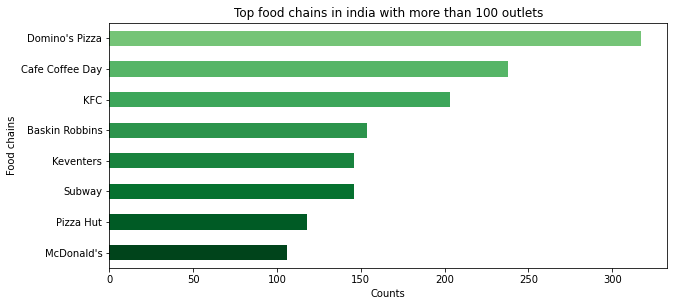

In [108]:
# Top Food chains in indian with more than 100 outlets
top_food_chains= df.name.value_counts(ascending=True)
top_food_chains[top_food_chains >= 100].plot(kind='barh',figsize= (10,4.5), color= get_color_codes('Greens_r',15))
plt.xlabel('Counts')
plt.ylabel('Food chains')
plt.title('Top food chains in india with more than 100 outlets')
plt.show()

Dominos has maximum numbers of outlets in India, followed by Cafe Coffee Dat and KFC.

In [109]:
# Top rated restaurants with more than 5000 reviews
grped_rest= df.groupby(['name','state','city','type'])['aggregate_rating','votes'].mean().reset_index()
top_rests= grped_rest[grped_rest.votes >= 5000].set_index('name').groupby(['city','type']).agg({'aggregate_rating': [pd.Series.idxmax, 'mean']})
(top_rests.rename({'idxmax':'Restaurant Name','mean':'Ratings','aggregate_rating':''}, axis=1))\
                        .style.set_precision(1)\
                        .set_caption('Top rated restaurants with more than 5000 reviews')

In [110]:
# Best restaurants of each top city by type and overall ratings
top_cities= df.city.value_counts()[:10].index.to_list()
grped_rest= df[df.city.isin(top_cities)].groupby(['name','city','type']).mean()[['aggregate_rating','votes']].reset_index()
grped_rest= grped_rest.set_index('aggregate_rating').groupby(['name','city','type']).votes.idxmax()
grped_rest= grped_rest.reset_index().set_index('name').groupby(['city','type']).agg({'votes': [pd.Series.idxmax, 'mean']})
print('Best restaurants in top cities by restaurant type and overall ratings')
grped_rest.style.set_precision(1)

Best restaurants in top cities by restaurant type and overall ratings


In [111]:
top_cities= df.city.value_counts()[:10].index.to_list()
top_rest_by_cost= df[df.city.isin(top_cities)].groupby(['city','name','type']).agg({'average_cost_for_two':'mean','votes':'mean','aggregate_rating':'mean'}).reset_index()
top_rest_by_cost= top_rest_by_cost[top_rest_by_cost.aggregate_rating >= 4].set_index('average_cost_for_two').groupby(['name','city','type']).agg({'votes':'idxmax'}).reset_index()
top_rest_by_cost= top_rest_by_cost.set_index('name').groupby(['city','type']).votes.agg(['idxmin','idxmax']).rename({'idxmin':'Cheapest', 'idxmax': 'Costliest'},axis=1)
print('Best cheapest and costliest restaurants in top cities by restaurant type')
top_rest_by_cost

Best cheapest and costliest restaurants in top cities by restaurant type


Cheapest  \
city       type                                                                      
Ahmedabad  Bakery, desserts & Confectionary                      Ambica Dughdhalay   
           Casual Dining                                                  La Bella   
           Fine Dining                           MoMo Café - Courtyard By Marriott   
           Pubs, Bars & Cafes                                   Danny's Coffee Bar   
           Quick Bites                                           Indore Chat House   
Bangalore  Bakery, desserts & Confectionary                       Amrith Ice Cream   
           Casual Dining                                                 Iyer Mess   
           Fine Dining                                Tijouri - Radisson Blu Atria   
           Pubs, Bars & Cafes                                            Chai Days   
           Quick Bites                                               Arogya Ahaara   
Chennai    Bakery, desserts & Confectionary                           Bombay Kulfi   
           Casual Dining                                              Rayar's Mess   
           Fine Dining                                   Chin Chin - The Residency   
           Pubs, Bars & Cafes                                                 90ML   
           Quick Bites                                                  Mamee Soup   
Coimbatore Bakery, desserts & Confectionary                                Bakeroe   
           Casual Dining                                       Lakshmi Sankar Mess   
           Fine Dining                       Kovai Kitchen - Fairfield By Marriott   
           Pubs, Bars & Cafes                                           Bench Cafe   
           Quick Bites                                                 Geetha Cafe   
Indore     Bakery, desserts & Confectionary                         Rasgulla House   
           Casual Dining                                 Maa Anusuiyaa Bhojanalaya   
           Fine Dining                         54 Praangan - Indore Marriott Hotel   
           Pubs, Bars & Cafes                                  Ovenly by Khurana's   
           Quick Bites                                       Joshi Dahi Bada House   
Jaipur     Bakery, desserts & Confectionary                     Naturals Ice Cream   
           Casual Dining                                         Ganesh Bhojnalaya   
           Fine Dining                                                      Zarpar   
           Pubs, Bars & Cafes                                            Kafeholic   
           Quick Bites                                               Gulab Ji Chai   
Kochi      Bakery, desserts & Confectionary                Snoosh Ice Cream Palour   
           Casual Dining                                            Arabian Palace   
           Fine Dining                                        51 - Xandari Harbour   
           Pubs, Bars & Cafes                                              Carrots   
           Quick Bites                                         Kerala Flood Relief   
Kolkata    Bakery, desserts & Confectionary                     Anandamayee Sweets   
           Casual Dining                                             Allen Kitchen   
           Fine Dining                                                     Riyasat   
           Pubs, Bars & Cafes                                        Beans n Bites   
           Quick Bites                                         Adil Biryani Centre   
Lucknow    Bakery, desserts & Confectionary            Panditji Ke Dehati Rasgulle   
           Casual Dining                                                  Al-Baike   
           Fine Dining                                               Eatery Castle   
           Pubs, Bars & Cafes                                Rooftop Bar - Novotel   
           Quick Bites                                    Bajpayee Kachodi Bhandar   
New Delhi  Bakery, desserts & Co

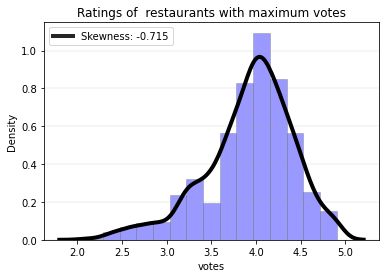

In [112]:
# Histogram for ratings of  restaurants with maximum votes
rating_of_most_voted_restaurants= df.set_index('aggregate_rating').groupby('locality').votes.idxmax()
sns.distplot(rating_of_most_voted_restaurants, bins=15,
             hist_kws={'edgecolor':'grey', 'color':'blue'}, kde_kws={'lw':4, 'color':'black', 'alpha':0.85})
plt.legend(handles= [lines.Line2D(xdata=[], ydata=[],linewidth=4, color='black', alpha=0.85, label= 'Skewness: %.3f'%rating_of_most_voted_restaurants.skew())])
plt.grid(axis='y', lw=0.4,alpha=0.5)
plt.title('Ratings of  restaurants with maximum votes')
plt.show()

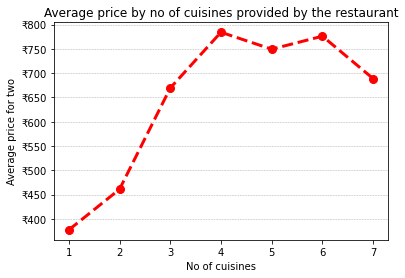

In [113]:
plt.plot(df.groupby('cuisine_count').average_cost_for_two.mean()[:-1], '--or', markersize=8, lw=3)
plt.title('Average price by no of cuisines provided by the restaurant')
plt.grid(axis='y', lw=.5, ls='--')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:.0f}'))
plt.xlabel('No of cuisines')
plt.ylabel('Average price for two')
plt.show()

As we can see, with increase in number of cuisines, the average price for eating also increases

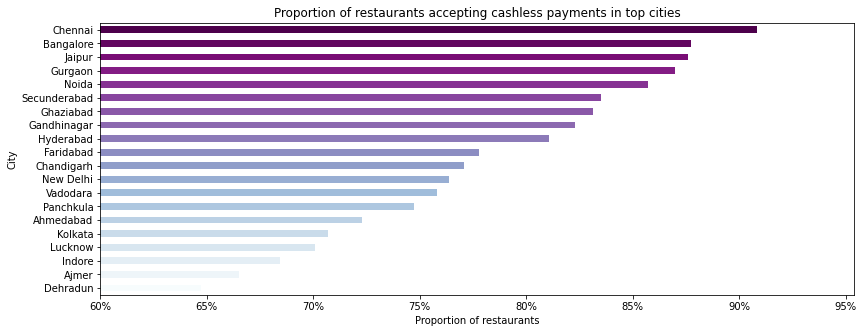

In [114]:
# Proportion of restaurants accepting cashless payments in top cities
cashless= ['Digital Payments Accepted','Credit Card','Debit Card']
filters= df.high.apply(lambda x: any(includes(x, cashless)))
cashless_rest= df[filters].city.value_counts().sort_index()
rest_by_cities= df.city.value_counts().sort_index()
(cashless_rest/rest_by_cities).sort_values()[-20:].plot(kind='barh', color= get_color_codes(plt.cm.BuPu, 20), figsize= (13.5,5))
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
plt.xlabel('Proportion of restaurants')
plt.ylabel('City')
plt.xlim(.6,)
plt.title('Proportion of restaurants accepting cashless payments in top cities')
plt.show()

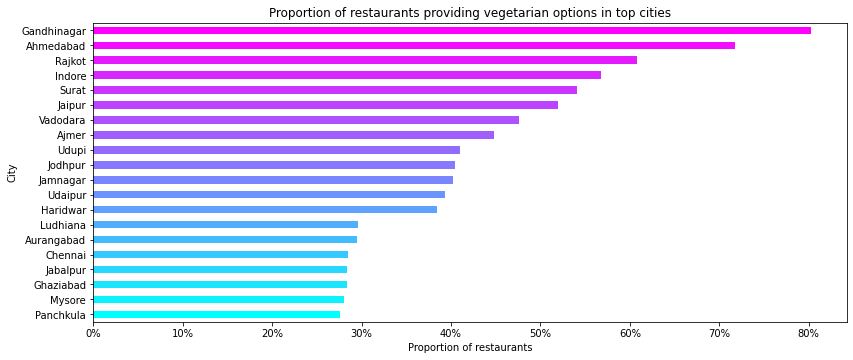

In [115]:
# Proportion of restaurants providing vegetarian and vegan options in top cities
filters= df.high.apply(lambda x: any(includes(x, ['Pure Veg','Vegan Options'])))
veg_rest= df[filters].city.value_counts().sort_index()
(veg_rest/rest_by_cities).sort_values()[-20:].plot(kind='barh', color= get_color_codes(plt.cm.cool,20), figsize=(13.5,5.5))
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
plt.xlabel('Proportion of restaurants')
plt.ylabel('City')
plt.title('Proportion of restaurants providing vegetarian options in top cities')
plt.show()

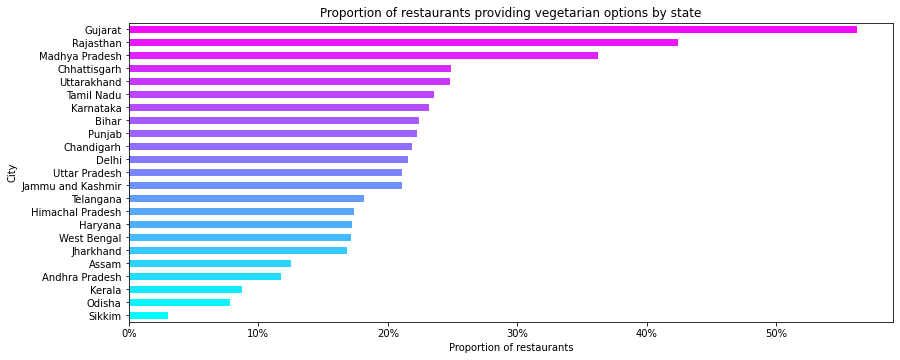

In [116]:
filters= df.high.apply(lambda x: any(includes(x, ['Pure Veg','Vegan Options'])))
veg_rest= df[filters].state.value_counts().sort_index()
rest_by_states= df.state.value_counts().sort_index()
(veg_rest/rest_by_states).sort_values().plot(kind='barh', figsize=(13.7,5.5), color= get_color_codes('cool', 24))
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
plt.xlabel('Proportion of restaurants')
plt.ylabel('City')
plt.title('Proportion of restaurants providing vegetarian options by state')
plt.show()

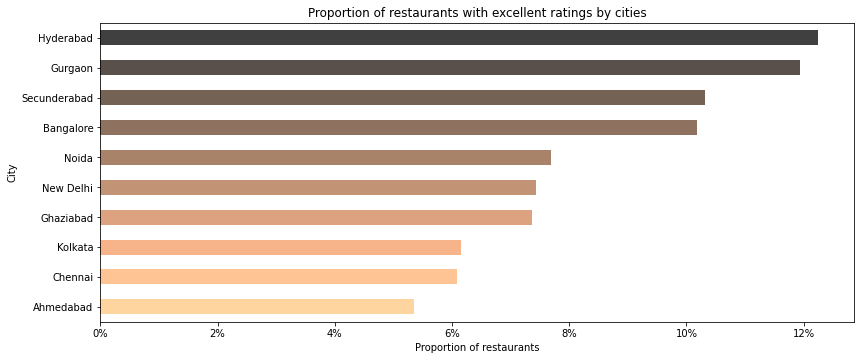

In [117]:
rest_with_excellent_ratings= df[df.aggregate_rating >= 4.5]
(rest_with_excellent_ratings.city.value_counts().sort_index()/df.city.value_counts()\
                                                .sort_index()).dropna().sort_values()[-10:]\
                                                .plot(kind='barh', figsize= (13.5,5.5),color= get_color_codes(plt.cm.copper_r, 10), alpha=0.75)
plt.title('Proportion of restaurants with excellent ratings by cities')
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))
plt.xlabel('Proportion of restaurants')
plt.ylabel('City')
plt.show()

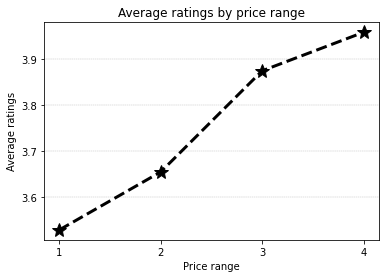

In [118]:
plt.plot(df.groupby('price_range').aggregate_rating.mean(), '*--',color='black', lw=3, markersize= 15)
plt.xticks(ticks= range(1,5), labels= range(1,5))
plt.title('Average ratings by price range')
plt.xlabel('Price range')
plt.ylabel('Average ratings')
plt.grid(axis='y', lw=0.4, ls='--')
plt.show()

In [119]:
def outliers(data):
    q1= data.quantile(.25)
    q3= data.quantile(.75)
    iqr= q3-q1
    l= q1 - (1.5*iqr)
    r= q3 +(1.5*iqr)
    return ((data < l) | (data > r)) 

In [120]:
print('Localities where the best restaurants could be found in top 10 cities')
df[df.aggregate_rating >= 4.5].set_index('locality').groupby('city').votes.idxmax()[top_cities]

Localities where the best restaurants could be found in top 10 cities


city
Chennai                      T. Nagar
Bangalore               Sarjapur Road
New Delhi           Hauz Khas Village
Jaipur                  Shastri Nagar
Kolkata       RDB Boulevard, Sector 5
Ahmedabad                     Thaltej
Lucknow                      Aminabad
Indore          56 Dukan, New Palasia
Kochi            LuLu Mall, Edappally
Coimbatore                  Town Hall
Name: votes, dtype: object

In [121]:
# Top cities with best North indian food
north_indian= df[df.cuisines.apply(lambda x: any(includes(x, ['North Indian'])))]
north_indian_rests= north_indian.city.value_counts().sort_index()
top_cities= north_indian_rests[north_indian_rests >= 200].index.to_list()
filters= (north_indian.aggregate_rating >= 4.5) & (north_indian.average_cost_for_two <= 1500) & (north_indian.city.isin(top_cities))
top_north_indian_rests= north_indian[filters].city.value_counts().sort_index()
print('Top cities with best North indian food')
(top_north_indian_rests/north_indian_rests).dropna().sort_values()[-10:].index.to_list()

Top cities with best North indian food


['Ahmedabad',
 'Patna',
 'Indore',
 'Jaipur',
 'Vadodara',
 'New Delhi',
 'Gurgaon',
 'Chennai',
 'Bangalore',
 'Hyderabad']

In [122]:
# Top cities with best south indian food
south_indian= df[df.cuisines.apply(lambda x: any(includes(x, ['South Indian'])))]
south_indian_rests= south_indian.city.value_counts().sort_index()
top_cities= south_indian_rests[south_indian_rests >= 200].index.to_list()
filters= (south_indian.aggregate_rating >= 4.5) & (south_indian.average_cost_for_two <= 1200) & (south_indian.city.isin(top_cities))
top_south_indian_rests= south_indian[filters].city.value_counts().sort_index()
print('Top cities with best South indian food')
(top_south_indian_rests/south_indian_rests).dropna().sort_values().index.to_list()

Top cities with best South indian food


['Chennai', 'Madurai', 'Coimbatore', 'Bangalore']

In [123]:
# Top cities with best chinese food
chinese= df[df.cuisines.apply(lambda x: any(includes(x, ['Chinese'])))]
chinese_rests= chinese.city.value_counts().sort_index()
top_cities= chinese_rests[chinese_rests >= 200].index.to_list()
filters= (chinese.aggregate_rating >= 4.5) & (chinese.average_cost_for_two <= 1200) & (chinese.city.isin(top_cities))
top_chinese_rests= chinese[filters].city.value_counts().sort_index()
print('Top cities with best Chinese food')
(top_chinese_rests/chinese_rests).dropna().sort_values().index.to_list()[-10:]

Top cities with best Chinese food


['Dehradun',
 'Guwahati',
 'New Delhi',
 'Bangalore',
 'Indore',
 'Patna',
 'Chennai',
 'Kolkata',
 'Bhopal',
 'Jaipur']

In [124]:
# Top cities where best quality sweets and desserts could be found
sweets= df[df.cuisines.apply(lambda x: any(includes(x, ['Mithai','Mishti','Desserts'])))]
sweets_rests= sweets.city.value_counts().sort_index()
top_cities= sweets_rests[sweets_rests >= 200].index.to_list()
filters= (sweets.aggregate_rating >= 4.5) & (sweets.average_cost_for_two <= 1000) & (sweets.city.isin(top_cities))
top_sweets= sweets[filters].city.value_counts().sort_index()
print('Top cities where best quality sweets and desserts could be found')
(top_sweets/sweets_rests).dropna().sort_values(ascending=False).index.to_list()[:5]

Top cities where best quality sweets and desserts could be found


['Bangalore', 'Ahmedabad', 'Chennai', 'Lucknow', 'Kolkata']

In [125]:
df.groupby('city').veg.value_counts(normalize=True).unstack()[0].sort_values()[-10:]

city
Vijayawada    0.887405
Siliguri      0.900621
Kochi         0.902629
Srinagar      0.912000
Cuttack       0.921502
Patiala       0.928713
Thrissur      0.950617
Alappuzha     0.951311
Gangtok       0.969697
Kharagpur     0.991379
Name: 0, dtype: float64

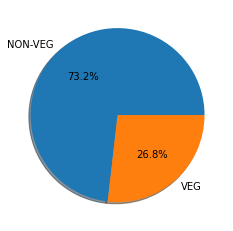

In [126]:
plt.pie(df.veg.value_counts(),labels=['NON-VEG','VEG'], shadow=True, autopct='%.1f%%')
plt.show()

## **Find Any Restaurant**

In [127]:
# Function for finding a restaurant of any choice.
def find_top_restaurants(city, size='all',cuisines=None, price_for_two=None, rating=None, votes=None, hashtags=None, veg=None):
    capitalize_text= lambda text:' '.join([i.capitalize() for i in text.split(' ')])
    def flatten(t):
        return [item for sublist in t for item in sublist]
#####################################################################################
    data= df[df.city.str.contains(capitalize_text(city))] # Filter city
    # filter cuisines
    if veg is not None:
        if veg==True:
            data= data[data.veg==1]
        else:
            data= data[data.veg==0]
######################################################################################
    if cuisines is not None:
        cuisines= flatten([[i for i in list(data.cuisines.explode().unique()) if capitalize_text(t) in i] for t in cuisines])
        data= data[data.cuisines.apply(lambda x: any(includes(x,cuisines)))]
    else: pass
###################################################################################### 
    # filter prices
    if price_for_two is not None:
        filters= (data.average_cost_for_two <= price_for_two)
        data= data[filters]
    else: pass
#####################################################################################
    # filter ratings
    if rating is not None: data= data[(data.aggregate_rating >= rating)]
    else: pass
#####################################################################################
    # Hashtags
    if hashtags is not None:
        hashtags= flatten([[i for i in list(data.high.explode().unique()) if capitalize_text(t) in i] for t in hashtags])
        data= data[data.high.apply(lambda x: any(includes(x,hashtags)))]
    else: pass
#####################################################################################
    data['locality']= data['locality']+', '+ data.city # Concatenate locality with city
    # sort values
    data= data.sort_values(by=['average_cost_for_two','votes','aggregate_rating'], ascending=False).reset_index(drop=True)
######################################################################################
    renamed_cols= ['Restaurant Name','Address(Locality)','Highlights','Rating', 'Price','cuisines']
    cols= ['name','locality','high','aggregate_rating', 'average_cost_for_two','cuisines']
    data= data.rename(dict(zip(cols, renamed_cols)), axis=1)[renamed_cols] # Renaming columns
######################################################################################    
    if size=='all':
        return data[:].style.format({'Price': '₹{:.0f}', 'Rating': '{:.1f}'})
    else:
        return data[:size].style.format({'Price': '₹{:.0f}', 'Rating': '{:.1f}'}) # Format Ratings and Price

In [128]:
find_top_restaurants('Patna', price_for_two=500, rating=4.0, size=5, veg=False, cuisines= ['mughlai'])

,Restaurant Name,Address(Locality),Highlights,Rating,Price,cuisines
0,Biryani Mahal,"Khajpura, Patna","['Credit Card', 'Lunch', 'Delivery', 'Cash', 'Debit Card', 'Dinner', 'Takeaway Available', 'Indoor Seating', 'Air Conditioned', 'Table Reservation Not Required']",4.2,₹500,"['Biryani', 'Mughlai']"
1,Biryani Mahal,"Kankarbagh, Patna","['Takeaway Available', 'Cash', 'Credit Card', 'Dinner', 'Debit Card', 'Lunch', 'Indoor Seating', 'Table booking recommended', 'Air Conditioned']",4.0,₹500,['Mughlai']
2,Arsalan Biryani,"Phulwari Sharif, Patna","['Cash', 'Takeaway Available', 'Dinner', 'Delivery', 'Lunch', 'Indoor Seating', 'Outdoor Seating']",4.1,₹500,"['Biryani', 'Mughlai']"
3,Biryani King,"Bakerganj, Patna","['Dinner', 'Delivery', 'Credit Card', 'Lunch', 'Cash', 'Takeaway Available', 'Debit Card', 'Indoor Seating', 'Table Reservation Not Required', 'Air Conditioned']",4.1,₹500,"['Biryani', 'North Indian', 'Mughlai', 'Chinese']"
4,Red Chilli,"Khajpura, Patna","['Lunch', 'Delivery', 'Credit Card', 'No Alcohol Available', 'Dinner', 'Cash', 'Takeaway Available', 'Debit Card', 'Indoor Seating', 'Digital Payments Accepted', 'Table Reservation Not Required', 'Air Conditioned']",4.0,₹450,"['Chinese', 'North Indian', 'Mughlai']"
